# Chapter 10. Relational Data with dplyr

In [1]:
options(repr.plot.width = 8, repr.plot.height = 6)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Introduction

> Collectively, multiple tables of data are called *relational data* because it is the relations, not just the individual datasets, that are important.

> There are three families of verbs designed to work with relational data:
> - *Mutating joins*, which add new variables to one data frame from matching observations in another.
> - *Filtering joins*, which filter observations from one data frame based on whether or not they match an observation in the other table.
> - *Set operations*, which treat observations as if they were set elements.

## nycflights13

> <img width="800" src="https://web.archive.org/web/20201229081951if_/https://learning.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in01.png" />

### Exercises

1. Imagine you wanted to draw (approximately) the route each plane flies from its origin to its destination. What variables would you need? What tables would you need to combine?
1. I forgot to draw the relationship between `weather` and `airports`. What is the relationship and how should it appear in the diagram?
1. `weather` only contains information for the origin (NYC) airports. If it contained weather records for all airports in the USA, what additional relation would it define with `flights`?
1. We know that some days of the year are “special,” and fewer people than usual fly on them. How might you represent that data as a data frame? What would be the primary keys of that table? How would it connect to the existing tables?

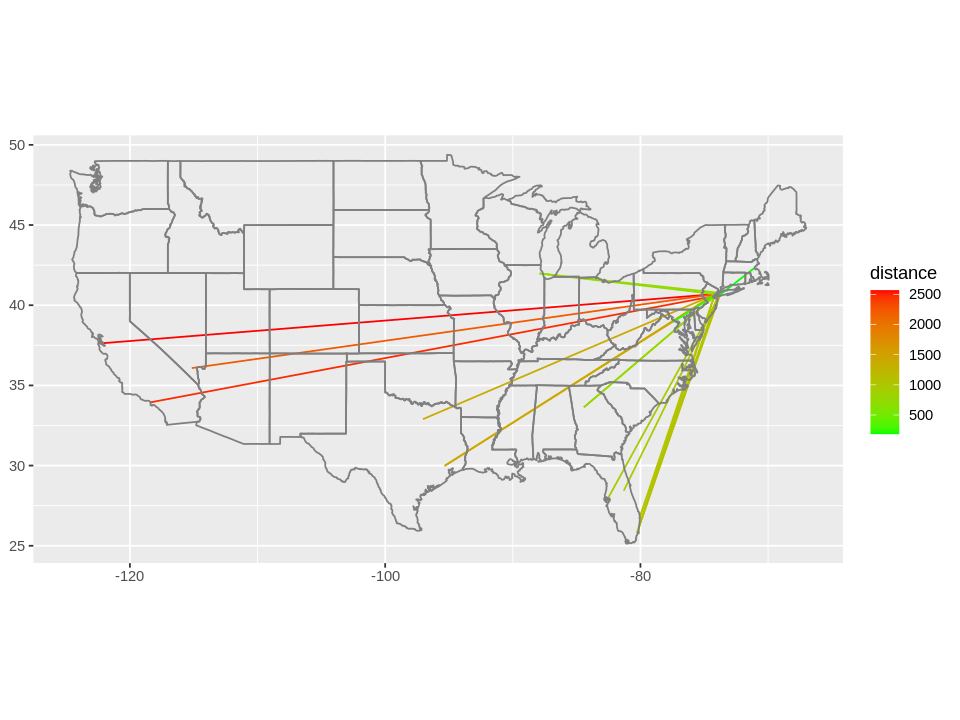

In [2]:
# 1.
bind_rows(
  head(nycflights13::flights, 20) %>%
    inner_join(nycflights13::airports, by = c("origin" = "faa")) %>%
    select(flight, origin, dest, distance, lon, lat),

  head(nycflights13::flights, 20) %>%
    inner_join(nycflights13::airports, by = c("dest" = "faa")) %>%
    select(flight, origin, dest, distance, lon, lat)
) %>%

  qplot(lon, lat, group = flight, color = distance, data = ., geom = "line") +
  borders("state") +
  coord_quickmap() +
  scale_color_gradient(low = "green", high = "red") +
  labs(x = NULL, y = NULL)

## Keys

> The variables used to connect each pair of tables are called *keys*. A key is a variable (or set of variables) that uniquely identifies an observation.

> There are two types of keys:
> - *A primary key* uniquely identifies an observation in its own table. For example, `planes$tailnum` is a primary key because it uniquely identifies each plane in the `planes` table.
> - *A foreign key* uniquely identifies an observation in another table. For example, `flights$tailnum` is a foreign key because it appears in the `flights` table where it matches each flight to a unique plane.

> A variable can be both a primary key and a foreign key.

> Once you’ve identified the primary keys in your tables, it’s good practice to verify that they do indeed uniquely identify each observation.

> Sometimes a table doesn’t have an explicit primary key: each row is an observation, but no combination of variables reliably identifies it. If a table lacks a primary key, it’s sometimes useful to add one with `mutate()` and `row_number()`. That makes it easier to match observations if you’ve done some filtering and want to check back in with the original data. This is called a *surrogate key*.

> A primary key and the corresponding foreign key in another table form a *relation*.

In [3]:
nycflights13::weather %>%
  count(origin, year, month, day, hour) %>%
  filter(n > 1) %>%
  print

# A tibble: 3 x 6
  origin  year month   day  hour     n
  <chr>  <int> <int> <int> <int> <int>
1 EWR     2013    11     3     1     2
2 JFK     2013    11     3     1     2
3 LGA     2013    11     3     1     2


### Exercises

1. Add a surrogate key to `flights`.

1. Identify the keys in the following datasets:

    1. `Lahman::Batting`
    1. `babynames::babynames`
    1. `nasaweather::atmos`
    1. `fueleconomy::vehicles`
    1. `ggplot2::diamonds`

    (You might need to install some packages and read some documentation.)

1. Draw a diagram illustrating the connections between the `Batting`, `Master`, and `Salaries` tables in the **Lahman** package. Draw another diagram that shows the relationship between `Master`, `Managers`, and `AwardsManagers`.

    How would you characterize the relationship between the `Batting`, `Pitching`, and `Fielding` tables?

In [4]:
# 1.
colnames(nycflights13::flights)

nycflights13::flights %>%
  count(year, month, day, flight) %>%
  filter(n > 1) %>%
  print

nycflights13::flights %>%
  mutate(id = row_number()) %>%
  select(id, everything()) %>%
  print

[1] "year"           "month"          "day"            "dep_time"      
 [5] "sched_dep_time" "dep_delay"      "arr_time"       "sched_arr_time"
 [9] "arr_delay"      "carrier"        "flight"         "tailnum"       
[13] "origin"         "dest"           "air_time"       "distance"      
[17] "hour"           "minute"         "time_hour"

# A tibble: 29,768 x 5
    year month   day flight     n
   <int> <int> <int>  <int> <int>
 1  2013     1     1      1     2
 2  2013     1     1      3     2
 3  2013     1     1      4     2
 4  2013     1     1     11     3
 5  2013     1     1     15     2
 6  2013     1     1     21     2
 7  2013     1     1     27     4
 8  2013     1     1     31     2
 9  2013     1     1     32     2
10  2013     1     1     35     2
# … with 29,758 more rows
# A tibble: 336,776 x 20
      id  year month   day dep_time sched_dep_time dep_delay arr_time
   <int> <int> <int> <int>    <int>          <int>     <dbl>    <int>
 1     1  2013     1     1      517            515         2      830
 2     2  2013     1     1      533            529         4      850
 3     3  2013     1     1      542            540         2      923
 4     4  2013     1     1      544            545        -1     1004
 5     5  2013     1     1      554            600        -6      812
 6     6  2013     1     1  

In [5]:
# 2.
head(Lahman::Batting)
all(count(Lahman::Batting, playerID, yearID, stint)$n == 1)

head(babynames::babynames)
all(count(babynames::babynames, year, sex, name)$n == 1)

head(nasaweather::atmos)
all(count(nasaweather::atmos, year, month, lat, long)$n == 1)

head(fueleconomy::vehicles)
all(count(fueleconomy::vehicles, id)$n == 1)

head(ggplot2::diamonds)
all(count(ggplot2::diamonds, vars(colnames(ggplot2::diamonds)))$n == 1)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
,<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,abercda01,1871,1,TRO,NA,1,4,0,0,0,⋯,0,0,0,0,0,NA,NA,NA,NA,0
2,addybo01,1871,1,RC1,NA,25,118,30,32,6,⋯,13,8,1,4,0,NA,NA,NA,NA,0
3,allisar01,1871,1,CL1,NA,29,137,28,40,4,⋯,19,3,1,2,5,NA,NA,NA,NA,1
4,allisdo01,1871,1,WS3,NA,27,133,28,44,10,⋯,27,1,1,0,2,NA,NA,NA,NA,0
5,ansonca01,1871,1,RC1,NA,25,120,29,39,11,⋯,16,6,2,2,1,NA,NA,NA,NA,0
6,armstbo01,1871,1,FW1,NA,12,49,9,11,2,⋯,5,0,1,0,1,NA,NA,NA,NA,0


[1] TRUE

year,sex,name,n,prop
<dbl>,<chr>,<chr>,<int>,<dbl>
1880,F,Mary,7065,0.07238359
1880,F,Anna,2604,0.02667896
1880,F,Emma,2003,0.02052149
1880,F,Elizabeth,1939,0.01986579
1880,F,Minnie,1746,0.01788843
1880,F,Margaret,1578,0.01616720


[1] TRUE

lat,long,year,month,surftemp,temp,pressure,ozone,cloudlow,cloudmid,cloudhigh
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36.20000,-113.8,1995,1,272.7,272.1,835,304,7.5,34.5,26.0
33.70435,-113.8,1995,1,279.5,282.2,940,304,11.5,32.5,20.0
31.20870,-113.8,1995,1,284.7,285.2,960,298,16.5,26.0,16.0
28.71304,-113.8,1995,1,289.3,290.7,990,276,20.5,14.5,13.0
26.21739,-113.8,1995,1,292.2,292.7,1000,274,26.0,10.5,7.5
23.72174,-113.8,1995,1,294.1,293.6,1000,264,30.0,9.5,8.0


[1] TRUE

id,make,model,year,class,trans,drive,cyl,displ,fuel,hwy,cty
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
13309,Acura,2.2CL/3.0CL,1997,Subcompact Cars,Automatic 4-spd,Front-Wheel Drive,4,2.2,Regular,26,20
13310,Acura,2.2CL/3.0CL,1997,Subcompact Cars,Manual 5-spd,Front-Wheel Drive,4,2.2,Regular,28,22
13311,Acura,2.2CL/3.0CL,1997,Subcompact Cars,Automatic 4-spd,Front-Wheel Drive,6,3.0,Regular,26,18
14038,Acura,2.3CL/3.0CL,1998,Subcompact Cars,Automatic 4-spd,Front-Wheel Drive,4,2.3,Regular,27,19
14039,Acura,2.3CL/3.0CL,1998,Subcompact Cars,Manual 5-spd,Front-Wheel Drive,4,2.3,Regular,29,21
14040,Acura,2.3CL/3.0CL,1998,Subcompact Cars,Automatic 4-spd,Front-Wheel Drive,6,3.0,Regular,26,17


[1] TRUE

carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48


[1] FALSE

## Mutating Joins

> This is why I call this type of join a mutating join. In this case, you could have got to the same place using `mutate()` and R’s base subsetting. But this is hard to generalize when you need to match multiple variables, and takes close reading to figure out the overall intent.

In [6]:
left_join(
  head(nycflights13::flights),
  nycflights13::airlines,
  by = "carrier"
)

mutate(
  head(nycflights13::flights),
  name = nycflights13::airlines$name[
    match(carrier, nycflights13::airlines$carrier)
  ]
)

year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
2013,1,1,517,515,2,830,819,11,UA,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
2013,1,1,533,529,4,850,830,20,UA,1714,N24211,LGA,IAH,227,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2013,1,1,542,540,2,923,850,33,AA,1141,N619AA,JFK,MIA,160,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
2013,1,1,544,545,-1,1004,1022,-18,B6,725,N804JB,JFK,BQN,183,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
2013,1,1,554,600,-6,812,837,-25,DL,461,N668DN,LGA,ATL,116,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.
2013,1,1,554,558,-4,740,728,12,UA,1696,N39463,EWR,ORD,150,719,5,58,2013-01-01 05:00:00,United Air Lines Inc.


year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
2013,1,1,517,515,2,830,819,11,UA,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
2013,1,1,533,529,4,850,830,20,UA,1714,N24211,LGA,IAH,227,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2013,1,1,542,540,2,923,850,33,AA,1141,N619AA,JFK,MIA,160,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
2013,1,1,544,545,-1,1004,1022,-18,B6,725,N804JB,JFK,BQN,183,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
2013,1,1,554,600,-6,812,837,-25,DL,461,N668DN,LGA,ATL,116,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.
2013,1,1,554,558,-4,740,728,12,UA,1696,N39463,EWR,ORD,150,719,5,58,2013-01-01 05:00:00,United Air Lines Inc.


### Inner Join

> <img width="800" src="https://web.archive.org/web/20201229100444if_/https://learning.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in04.png" />

> To be precise, this is an inner *equijoin* because the keys are matched using the equality operator. Since most joins are equijoins we usually drop that specification.

> The most important property of an inner join is that unmatched rows are not included in the result. This means that generally inner joins are usually not appropriate for use in analysis because it’s too easy to lose observations.

### Outer Joins

> - A *left join* keeps all observations in `x`.
> - A *right join* keeps all observations in `y`.
> - A *full join* keeps all observations in `x` and `y`.

> <img width="800" src="https://web.archive.org/web/20201229102721if_/https://www.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in06.png" />

> The left join should be your default join: use it unless you have a strong reason to prefer one of the others.

### Duplicate Keys

> <img width="800" src="https://web.archive.org/web/20201229105758if_/https://learning.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in08.png" />

> <img width="800" src="https://web.archive.org/web/20201229105804if_/https://learning.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in09.png" />

### Defining the Key Columns

> You can use other values for by to connect the tables in other ways:
> - The default, `by = NULL`, uses all variables that appear in both tables, the so-called *natural* join.
> - A character vector, `by = "x"`. This is like a natural join, but uses only some of the common variables.
> - A named character vector: `by = c("a" = "b")`. This will match variable `a` in table `x` to variable `b` in table `y`. The variables from `x` will be used in the output.

### Exercises

1. Compute the average delay by destination, then join on the `airports` data frame so you can show the spatial distribution of delays. Here’s an easy way to draw a map of the United States:

    ```r
    airports %>%
      semi_join(flights, c("faa" = "dest")) %>%
      ggplot(aes(lon, lat)) +
        borders("state") +
        geom_point() +
        coord_quickmap()
    ```

    (Don’t worry if you don’t understand what `semi_join()` does—you’ll learn about it next.)

    You might want to use the size or color of the points to display the average delay for each airport.

1. Add the location of the origin *and* destination (i.e., the `lat` and `lon`) to `flights`.
1. Is there a relationship between the age of a plane and its delays?
1. What weather conditions make it more likely to see a delay?
1. What happened on June 13, 2013? Display the spatial pattern of delays, and then use Google to cross-reference with the weather.

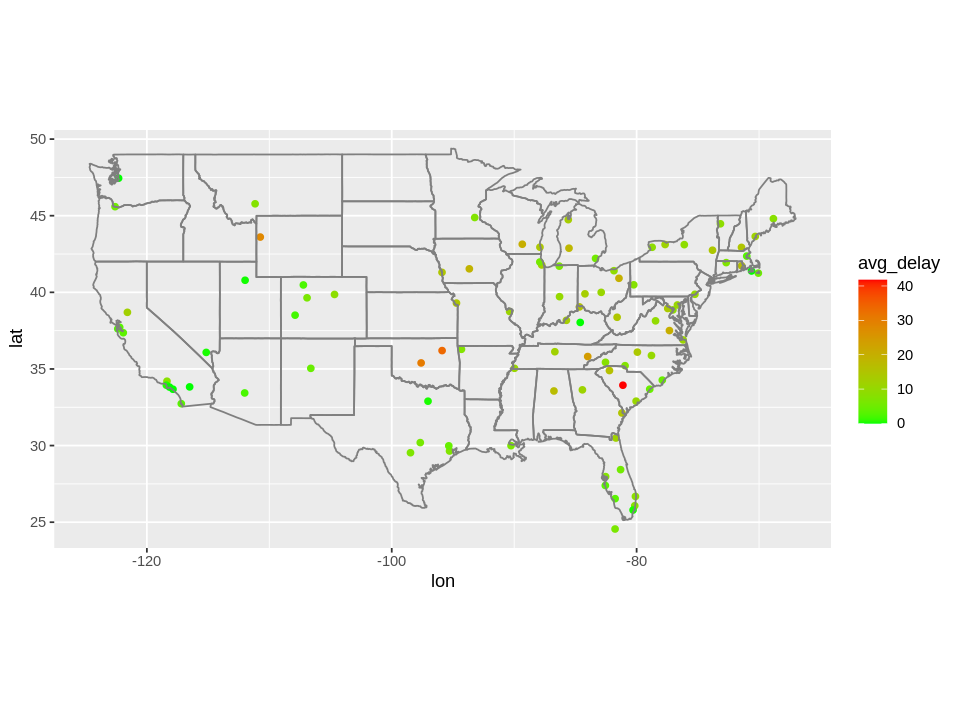

In [7]:
# 1.
nycflights13::flights %>%
  group_by(dest) %>%
  summarise(avg_delay = pmax(0, mean(arr_delay, na.rm = TRUE)), .groups = "drop") %>%
  inner_join(nycflights13::airports, by = c("dest" = "faa")) %>%
  filter(lon > -130) %>%

  qplot(lon, lat, color = avg_delay, data = .) +
  borders("state") +
  coord_quickmap() +
  scale_color_gradient(low = "green", high = "red")

In [8]:
# 2.
nycflights13::flights %>%
  inner_join(
    nycflights13::airports %>% rename_with(~str_c("origin_", .)),
    by = c("origin" = "origin_faa")
  ) %>%
  inner_join(
    nycflights13::airports %>% rename_with(~str_c("dest_", .)),
    by = c("dest" = "dest_faa")
  ) %>%
  select(matches("origin$|dest$|lat|lon")) %>%
  print

# A tibble: 329,174 x 6
   origin dest  origin_lat origin_lon dest_lat dest_lon
   <chr>  <chr>      <dbl>      <dbl>    <dbl>    <dbl>
 1 EWR    IAH         40.7      -74.2     30.0    -95.3
 2 LGA    IAH         40.8      -73.9     30.0    -95.3
 3 JFK    MIA         40.6      -73.8     25.8    -80.3
 4 LGA    ATL         40.8      -73.9     33.6    -84.4
 5 EWR    ORD         40.7      -74.2     42.0    -87.9
 6 EWR    FLL         40.7      -74.2     26.1    -80.2
 7 LGA    IAD         40.8      -73.9     38.9    -77.5
 8 JFK    MCO         40.6      -73.8     28.4    -81.3
 9 LGA    ORD         40.8      -73.9     42.0    -87.9
10 JFK    PBI         40.6      -73.8     26.7    -80.1
# … with 329,164 more rows


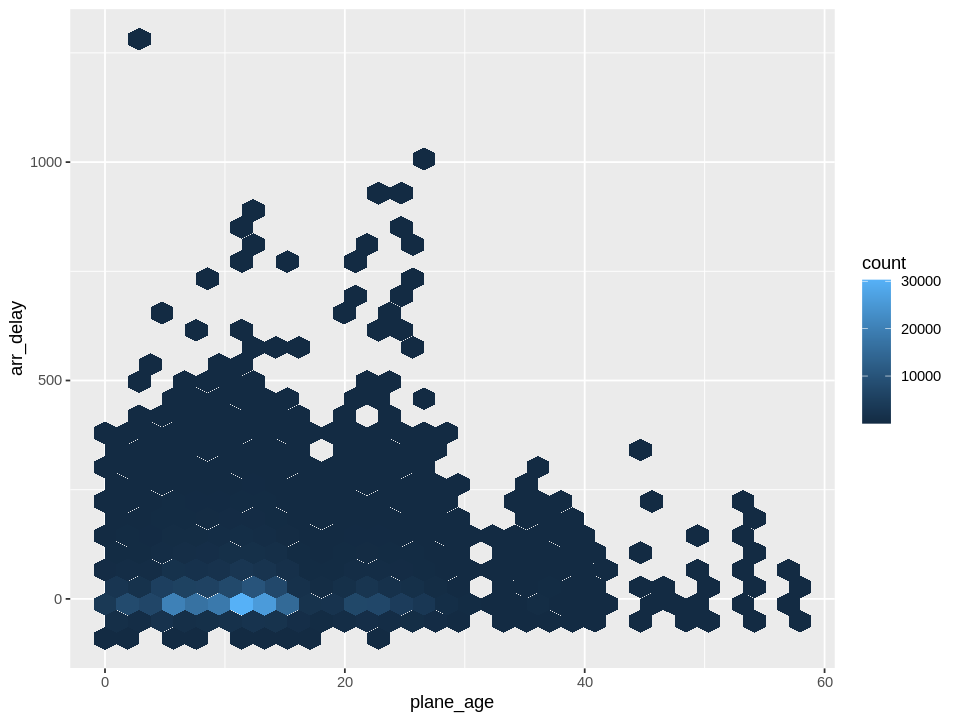

In [9]:
# 3.
inner_join(
  nycflights13::flights %>% transmute(arr_delay, tailnum, year),
  nycflights13::planes %>% select(tailnum, year),
  by = "tailnum",
  suffix = c("_of_flight", "_of_production")
) %>%
  mutate(plane_age = year_of_flight - year_of_production) %>%
  drop_na() %>%

  qplot(plane_age, arr_delay, data = ., geom = "hex")

### Filtering Joins

> - `semi_join(x, y)` keeps all observations in `x` that have a match in `y`.
> - `anti_join(x, y)` drops all observations in `x` that have a match in `y`.

In [10]:
nycflights13::flights %>%
  count(dest, sort = TRUE) %>%
  head(10)

semi_join(
  nycflights13::flights,
  nycflights13::flights %>%
    count(dest, sort = TRUE) %>%
    head(10),
  by = "dest"
) %>%
  print(width = Inf)

dest,n
<chr>,<int>
ORD,17283
ATL,17215
LAX,16174
BOS,15508
MCO,14082
CLT,14064
SFO,13331
FLL,12055
MIA,11728


# A tibble: 141,145 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      542            540         2      923            850
 2  2013     1     1      554            600        -6      812            837
 3  2013     1     1      554            558        -4      740            728
 4  2013     1     1      555            600        -5      913            854
 5  2013     1     1      557            600        -3      838            846
 6  2013     1     1      558            600        -2      753            745
 7  2013     1     1      558            600        -2      924            917
 8  2013     1     1      558            600        -2      923            937
 9  2013     1     1      559            559         0      702            706
10  2013     1     1      600            600         0      851            858
   arr_delay carrier flight

> Graphically, a semi-join looks like this:
>
> <img width="800" src="https://web.archive.org/web/20201229133147if_/https://www.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in10.png" />
>
> Only the existence of a match is important; it doesn’t matter which observation is matched. This means that filtering joins never duplicate rows like mutating joins do:
>
> <img width="800" src="https://web.archive.org/web/20201229133233if_/https://www.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in11.png" />
>
> The inverse of a semi-join is an anti-join. An anti-join keeps the rows that don’t have a match:
>
> <img width="800" src="https://web.archive.org/web/20201229133252if_/https://learning.oreilly.com/library/view/r-for-data/9781491910382/assets/rfds_10in12.png" />

In [11]:
nycflights13::flights %>%
  anti_join(nycflights13::planes, by = "tailnum") %>%
  count(tailnum, sort = TRUE) %>%
  print

# A tibble: 722 x 2
   tailnum     n
   <chr>   <int>
 1 NA       2512
 2 N725MQ    575
 3 N722MQ    513
 4 N723MQ    507
 5 N713MQ    483
 6 N735MQ    396
 7 N0EGMQ    371
 8 N534MQ    364
 9 N542MQ    363
10 N531MQ    349
# … with 712 more rows


### Exercises

1. What does it mean for a flight to have a missing `tailnum`? What do the tail numbers that don’t have a matching record in planes have in common? (Hint: one variable explains ~90% of the problems.)
1. Filter flights to only show flights with planes that have flown at least 100 flights.
1. Combine `fueleconomy::vehicles` and `fueleconomy::common` to find only the records for the most common models.
1. Find the 48 hours (over the course of the whole year) that have the worst delays. Cross-reference it with the weather data. Can you see any patterns?
1. What does `anti_join(flights, airports, by = c("dest" = "faa"))` tell you? What does `anti_join(airports, flights, by = c("faa" = "dest"))` tell you?
1. You might expect that there’s an implicit relationship between plane and airline, because each plane is flown by a single airline. Confirm or reject this hypothesis using the tools you’ve learned in the preceding section.

### Join Problems

1. Start by identifying the variables that form the primary key in each table. You should usually do this based on your understanding of the data, not empirically by looking for a combination of variables that give a unique identifier. If you just look for variables without thinking about what they mean, you might get (un)lucky and find a combination that’s unique in your current data but the relationship might not be true in general.
1. Check that none of the variables in the primary key are missing. If a value is missing then it can’t identify an observation!
1. Check that your foreign keys match primary keys in another table. The best way to do this is with an `anti_join()`. It’s common for keys not to match because of data entry errors. Fixing these is often a lot of work.

    If you do have missing keys, you’ll need to be thoughtful about your use of inner versus outer joins, carefully considering whether or not you want to drop rows that don’t have a match.

### Set Operations

In [12]:
df1 <- tribble(
  ~x, ~y,
  1, 1,
  2, 1
)
df2 <- tribble(
  ~x, ~y,
  1, 1,
  1, 2
)
union(df1, df2)
intersect(df1, df2)
setdiff(df1, df2)
setdiff(df2, df1)

x,y
<dbl>,<dbl>
1,1
2,1
1,2


x,y
<dbl>,<dbl>
1,1


x,y
<dbl>,<dbl>
2,1


x,y
<dbl>,<dbl>
1,2
